In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import robustranking as rr
import numpy as np
import requests
import re
import joblib
import logging
logging.basicConfig(level=logging.DEBUG)

import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

# Data processing

In [2]:
# urls = ["https://www.ini.rub.de/PEOPLE/glasmtbl/projects/bbcomp/results/BBComp2019-1OBJ/functionvalues.txt", "https://www.ini.rub.de/PEOPLE/glasmtbl/projects/bbcomp/results/BBComp2019-1OBJ-expensive/functionvalues.txt"]
# 


In [3]:
# dfs = []
# for url in urls:
#     response = requests.get(url)
#     print("got response")
#     response = str(response.text)
# 
#     columns = None
#     for line in response.split("\n"):
#             elements = re.split("\s{2,}", line)
#             if columns is None:
#                 columns = len(elements)
#                 performances = [[] for _ in elements]
#             elif columns != len(elements):
#                 print(f"Skipping line: '{line}'")
#                 continue
# 
#             for i, element in enumerate(elements):
#                 value = element
#                 if element == "none":
#                     value = np.inf
#                 elif re.match("\d+(\.\d+)?(e-\d+)?", element):
#                     value = float(element)
#                 performances[i].append(value)
#                 # print(value, type(value))
# 
#     df = {}            
#     for p in performances:
#         df[p[0]] = p[1:]
#     del df[""]
#     df = pd.DataFrame(df)
# 
#     dfs.append(df)

# Score calculation

In [4]:
# benchmarks = []
# for df in dfs:
#     # Get rankings (ASSUMES MINIMIZATION TARGET)
#     ranks = np.argsort(np.argsort(df.to_numpy()))+1
# 
#     # Ties https://www.ini.rub.de/PEOPLE/glasmtbl/projects/bbcomp/index.html#evaluation
#     scores = df.to_numpy()
#     tie_threshold = scores.min(axis=1) + np.clip(10e-14*scores.min(axis=1),0, 10e-20)
#     ties = scores < np.repeat(tie_threshold, scores.shape[1]).reshape(scores.shape)
#     ranks[ties] = 1
# 
#     rdf = pd.DataFrame(columns=df.columns, data=ranks)
# 
#     # Get score 
#     # score(k) = max { 0, log((n+1)/2) - log(k) }
#     # https://www.ini.rub.de/PEOPLE/glasmtbl/projects/bbcomp/faq.html#q4
# 
#     def score(k, n):
#         return max(0, np.log((n+1)/2) - np.log(k))
# 
#     rankscore = np.array([score(k, ranks.shape[1]) for k in ranks.flatten()]).reshape(ranks.shape)
#     rankscore.sum(axis=0)
# 
#     sdf = pd.DataFrame(columns=df.columns, data=rankscore)
# 
#     # VBS contribution
#     mdf = pd.DataFrame(columns=df.columns, data=ranks == 1)
# 
#     benchmark = pd.concat([sdf.stack(), rdf.stack(), mdf.stack()], axis=1).reset_index()
#     benchmark.columns = ["instance", "algorithm", "score", "rank", "contribution"]
#     benchmarks.append(benchmark)

In [5]:
# benchmark_normal, benchmark_expensive = benchmarks
# algorithms = list(set(benchmark_normal["algorithm"].unique()).intersection(benchmark_expensive["algorithm"]))
# benchmark_normal = benchmark_normal[benchmark_normal["algorithm"].isin(algorithms)]
# benchmark_expensive = benchmark_expensive[benchmark_expensive["algorithm"].isin(algorithms)]
# 
# benchmark_normal = benchmark_normal.set_index(["instance", "algorithm"])
# benchmark_normal.columns = ["scoreN", "rankN", "contributionN"]
# 
# benchmark_expensive = benchmark_expensive.set_index(["instance", "algorithm"])
# benchmark_expensive.columns = ["scoreE", "rankE", "contributionE"]
# 
# benchmark = pd.merge(benchmark_normal, benchmark_expensive, left_index=True, right_index=True).reset_index()

In [6]:
# benchmark = pd.concat([sdf.stack(), rdf.stack(), mdf.stack()], axis=1).reset_index()
# benchmark.columns = ["instance", "algorithm", "score", "rank", "contribution"]
# benchmark.head()

In [7]:
# competition = rr.Benchmark()
# competition.from_pandas(benchmark, instance_key="instance", algorithm_key="algorithm", objective_keys=["scoreN", "rankN", "contributionN", "scoreE", "rankE", "contributionE"])
# 
# competition.show_stats()
# 
# # joblib.dump(competition, "cec2019competition.pickle")

In [8]:
competition = joblib.load("cec2019competition.pickle")

In [9]:
competition.show_stats()

algorithms        9
instances      1000
objectives        6
values        54000
complete       True
dtype: object

# SO Robust ranking

In [10]:
s1comparison = rr.comparison.BootstrapComparison(competition.filter(objectives=["rankN"]),
                                               minimise=True,
                                               bootstrap_runs=10000,
                                               aggregation_method=np.sum)

s1ranking = s1comparison.get_ranking()

s2comparison = rr.comparison.BootstrapComparison(competition.filter(objectives=["rankE"]),
                                               minimise=True,
                                               bootstrap_runs=10000,
                                               aggregation_method=np.sum)

s2ranking = s2comparison.get_ranking()
# 
# comparison = rr.comparison.BootstrapComparison(competition.filter(objectives=["scoreN"]), minimise=False, aggregation_method=np.sum)
# normalcomp = rr.comparison.AggregatedComparison(competition.filter(objectives=["scoreN"]), minimise=False, aggregation_method=np.sum)
# result = comparison.get_ranking().merge(comparison.get_confidence_intervals(), left_index=True, right_index=True)
# result.merge(normalcomp.get_ranking(), left_index=True, right_index=True)
sbranking = s1ranking[["group"]].merge(s2ranking[["group"]], left_index=True, right_index=True, suffixes=("_rankN", "_rankE"))
sbranking

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
INFO:root:Round 0
INFO:root:> Nacim Belkhir has with 99.940% the most wins out of all 9 candidates.
INFO:root:	> Nacim Belkhir loses from Artelys 0.000% times.
INFO:root:	> Nacim Belkhir loses from Raphael Patrick Prager 0.000% times.
INFO:root:	> Nacim Belkhir loses from Jeremy 0.000% times.
INFO:root:	> Nacim Belkhir loses from avaneev 0.060% times.
INFO:root:	> Nacim Belkhir loses from mini-mlog 0.000% times.
INFO:root:	> Nacim Belkhir loses from GERAD 0.000% times.
INFO:root:	> Nacim Belkhir loses from V-Stanovov 0.000% times.
INFO:root:	> Nacim Belkhir loses from coco 0.000% times.
INFO:root:Round 1
INFO:root:> avaneev has with 99.990% the most wins out of all 8 candidates.
INFO:root:	> avaneev loses from Artelys 0.000% times.
INFO:root:	> avaneev loses from Raphael Pa

,group_rankN,group_rankE
algorithm,,
Nacim Belkhir,1,2
avaneev,2,2
V-Stanovov,3,5
mini-mlog,4,3
Artelys,4,1
GERAD,5,4
Jeremy,6,6
coco,7,7
Raphael Patrick Prager,7,8


In [11]:
dcomparison = rr.comparison.AggregatedComparison(competition.filter(objectives=["rankN", "rankE"]), minimise={f"rankN": True, f"rankE": True}, aggregation_method=np.sum)
dranking = dcomparison.get_ranking()

sbdranking = sbranking.merge(dranking, left_index=True, right_index=True)
sbdranking

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
/var/folders/b8/41_wfv893tnc356wksp2vkvw0000gn/T/ipykernel_20687/903030564.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  sbdranking = sbranking.merge(dranking, left_index=True, right_index=True)


,group_rankN,group_rankE,"(rankN, rank)","(rankN, score)","(rankE, rank)","(rankE, score)"
algorithm,,,,,,
Nacim Belkhir,1,2,1,3354.0,2,3223.0
avaneev,2,2,2,3724.0,3,3361.0
V-Stanovov,3,5,3,4176.0,6,4972.0
mini-mlog,4,3,4,4538.0,4,4215.0
Artelys,4,1,5,4678.0,1,2579.0
GERAD,5,4,6,6888.0,5,4727.0
Jeremy,6,6,7,7718.0,7,5921.0
coco,7,7,8,8147.0,8,7023.0
Raphael Patrick Prager,7,8,9,8195.0,9,8979.0


In [12]:
# plot_distributions_comparison(comparison, algorithms=competition.algorithms, show_p_values=False)
# plot_ci_list(comparison)

In [13]:
# comparison = BootstrapComparison(competition.filter(objectives=["rankN"]), minimise=True, aggregation_method=np.sum)
# normalcomp = AggregatedComparison(competition.filter(objectives=["rankN"]), minimise=True, aggregation_method=np.sum)
# result = comparison.get_ranking().merge(comparison.get_confidence_intervals(), left_index=True, right_index=True)
# result.merge(normalcomp.get_ranking(), left_index=True, right_index=True)

In [14]:
# plot_distributions_comparison(comparison, algorithms=competition.algorithms, show_p_values=False)
# plot_ci_list(comparison)

In [15]:
# comparison = BootstrapComparison(competition.filter(objectives=["contributionN"]), minimise=False, aggregation_method=np.mean)
# normalcomp = AggregatedComparison(competition.filter(objectives=["contributionN"]), minimise=False, aggregation_method=np.mean)
# result = comparison.get_ranking().merge(comparison.get_confidence_intervals(), left_index=True, right_index=True)
# result.merge(normalcomp.get_ranking(), left_index=True, right_index=True)

# Domination ranking

In [16]:
obj = "score"
comparison = rr.comparison.MODominationBootstrapComparison(competition.filter(objectives=[f"{obj}N", f"{obj}E"]), minimise={f"{obj}N": False, f"{obj}E": False}, aggregation_method=np.sum, bootstrap_runs=1000)
m1ranking = comparison.get_ranking()

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
DEBUG:root:flip obj
DEBUG:root:flip obj
INFO:root:Round 0
INFO:root:> Nacim Belkhir has with 100.000% the most wins out of all 9 candidates.
INFO:root:	> Nacim Belkhir loses from Artelys 0.000% times.
INFO:root:	> Nacim Belkhir loses from coco 0.000% times.
INFO:root:	> Nacim Belkhir loses from Raphael Patrick Prager 0.000% times.
INFO:root:	> Nacim Belkhir loses from Jeremy 0.000% times.
INFO:root:	> Nacim Belkhir loses from avaneev 0.000% times.
INFO:root:	> Nacim Belkhir loses from mini-mlog 0.000% times.
INFO:root:	> Nacim Belkhir loses from GERAD 0.000% times.
INFO:root:	> Nacim Belkhir loses from V-Stanovov 0.000% times.
INFO:root:Round 1
INFO:root:> Artelys has with 99.200% the most wins out of all 8 candidates.
INFO:root:	> Artelys loses from coco 0.000% times.
INFO

In [17]:
comparison.get_confidence_intervals()

,,median,lb,ub
algorithm,objective,,,
Artelys,ranking_score,6.5,6.5,6.5
coco,ranking_score,1.0,1.0,1.5
Raphael Patrick Prager,ranking_score,1.5,1.5,1.5
Jeremy,ranking_score,1.0,1.0,1.0
Nacim Belkhir,ranking_score,7.5,7.5,7.5
avaneev,ranking_score,6.5,6.5,6.5
mini-mlog,ranking_score,4.5,4.5,4.5
GERAD,ranking_score,3.0,2.5,3.0
V-Stanovov,ranking_score,4.5,4.5,4.5


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont:

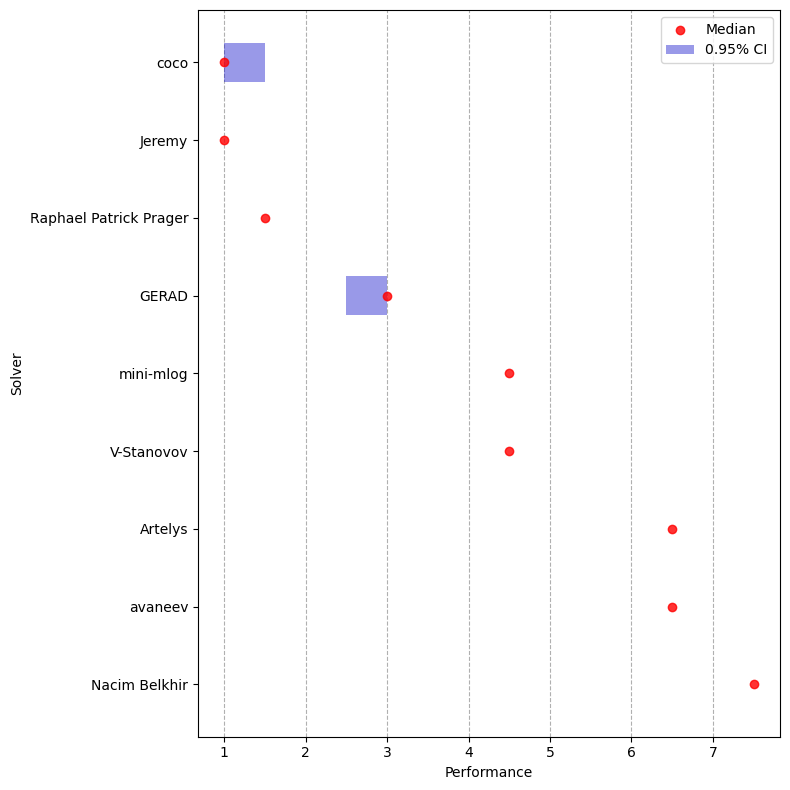

In [18]:
rr.utils.plots.plot_ci_list(comparison, objective="ranking_score")

In [19]:
isinstance(comparison, rr.comparison.MODominationBootstrapComparison)

True

In [20]:
type(comparison)

robustranking.comparison.mo_domination_bootstrap_comparison.MODominationBootstrapComparison

# MO Ranking

In [21]:
obj = "rank"
comparison = rr.comparison.MOBootstrapComparison(competition.filter(objectives=[f"{obj}N", f"{obj}E"]), 
                                                 minimise={f"{obj}N": True, f"{obj}E": True}, 
                                                 aggregation_method=np.sum, 
                                                 bootstrap_runs=10000)
ranking = comparison.get_ranking(visualise=False)
ranking

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
DEBUG:root:flip obj
DEBUG:root:flip obj
INFO:root:Round 0
DEBUG:root:candidates_mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True])
DEBUG:root:Artelys                        10000
DEBUG:root:coco                           0
DEBUG:root:Raphael Patrick Prager         0
DEBUG:root:Jeremy                         0
DEBUG:root:Nacim Belkhir                  10000
DEBUG:root:avaneev                        764
DEBUG:root:mini-mlog                      0
DEBUG:root:GERAD                          0
DEBUG:root:V-Stanovov                     0
INFO:root:2 winners found: ['Artelys', 'Nacim Belkhir']
INFO:root:	> Artelys is dominated by coco 0.000% times.
INFO:root:	> Artelys is dominated by Raphael Patrick Prager 0.000% times.
INFO:root:	> Artelys is dominated by

No candidates to compare


,algorithm,group,winner,ties,nd_rank_mean,nd_rank_median,nd_rank_ci_lb,nd_rank_ci_ub
id,,,,,,,,
0,Artelys,1,True,{},0.0000,0.0,0.0,0.0
4,Nacim Belkhir,1,True,{},0.0000,0.0,0.0,0.0
5,avaneev,2,True,{},0.9236,1.0,0.0,1.0
6,mini-mlog,3,True,{},1.9236,2.0,1.0,2.0
8,V-Stanovov,3,True,{},1.9236,2.0,1.0,2.0
7,GERAD,4,True,{},2.9236,3.0,2.0,3.0
3,Jeremy,5,True,{},3.9236,4.0,3.0,4.0
1,coco,6,True,{},4.9236,5.0,4.0,5.0
2,Raphael Patrick Prager,7,True,{},5.6129,6.0,5.0,6.0


In [22]:
table = ranking.set_index("algorithm").merge(sbdranking,left_index=True, right_index=True) 
# display(table.head())
# table = table[["group", "nd_rank_mean", "group_rankN", "group_rankE"]].round(0).astype(int)
# table["nd_rank_median"] += 1
# print(table.to_latex())

for algorithm, scores in table.iterrows():
    cells = [f"{algorithm}".replace("_", "\_")]
    cells.append(f"${scores['group']:.0f}$")
    cells.append(f"${scores['nd_rank_mean']+1:.1f}$")
    cells.append(f"${scores['group_rankN']:.0f}$")
    cells.append(f"${scores[('rankN', 'score')]:.0f}$")
    cells.append(f"${scores['group_rankE']:.0f}$")
    cells.append(f"${scores[('rankE', 'score')]:.0f}$") 
    print(" & ".join(cells)+" \\\\")

Artelys & $1$ & $1.0$ & $4$ & $4678$ & $1$ & $2579$ \\
Nacim Belkhir & $1$ & $1.0$ & $1$ & $3354$ & $2$ & $3223$ \\
avaneev & $2$ & $1.9$ & $2$ & $3724$ & $2$ & $3361$ \\
mini-mlog & $3$ & $2.9$ & $4$ & $4538$ & $3$ & $4215$ \\
V-Stanovov & $3$ & $2.9$ & $3$ & $4176$ & $5$ & $4972$ \\
GERAD & $4$ & $3.9$ & $5$ & $6888$ & $4$ & $4727$ \\
Jeremy & $5$ & $4.9$ & $6$ & $7718$ & $6$ & $5921$ \\
coco & $6$ & $5.9$ & $7$ & $8147$ & $7$ & $7023$ \\
Raphael Patrick Prager & $7$ & $6.6$ & $7$ & $8195$ & $8$ & $8979$ \\


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='ob

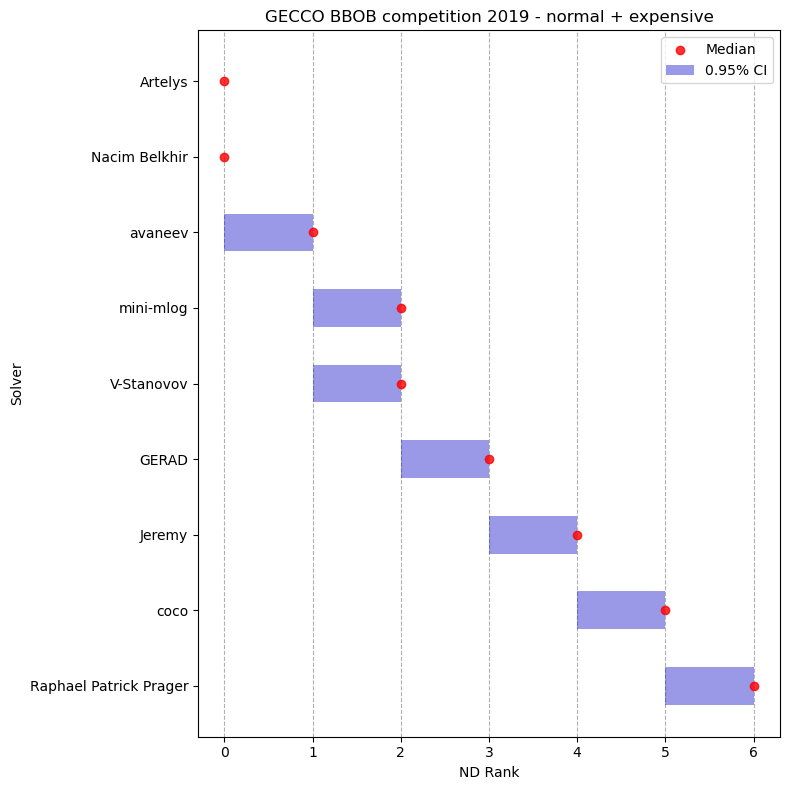

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
top = -1  # -1 shows all

cidf = ranking.sort_values("nd_rank_median", ascending=True)

means = []
yticks = []
handles = []

ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="--", zorder=-1)

n = len(cidf) if top <= 0 else min(len(cidf), top)
for i, (algorithm, bounds) in enumerate(cidf.iloc[:n].iterrows()):
    pos = n - i
    means.append([bounds["nd_rank_median"], pos])
    yticks.append(bounds["algorithm"])
    height = 0.5
    bar = patches.Rectangle(
        (bounds["nd_rank_ci_lb"], pos - (height / 2)),
        bounds["nd_rank_ci_ub"] - bounds["nd_rank_ci_lb"],
        height,
        facecolor=(0, 0, 0.78, 0.4),
        label="{:.2f}% CI".format(1 - comparison.alpha),
    )
    p = ax.add_patch(bar)

handles.append(ax.scatter(*zip(*means), color="red", label="Median", alpha=0.8))
handles.append(p)

ax.set_xlabel("ND Rank")
ax.set_ylabel("Solver")
ax.set_yticks(list(range(1, n + 1)))
ax.set_yticklabels(yticks[::-1])
ax.legend(handles=handles)
plt.title("GECCO BBOB competition 2019 - normal + expensive")
plt.tight_layout()
plt.show()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jeroen/Software/miniconda3/envs/EmpiricalComparison/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='ob

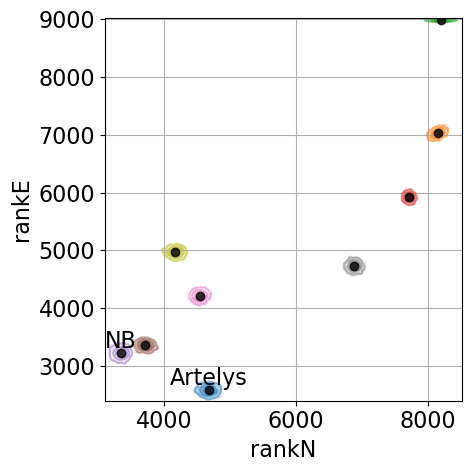

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(3,3))
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize=(5,5))


names = {c: ""for c in comparison.benchmark.algorithms}
names["Artelys"] = "Artelys"
names["Nacim Belkhir"] = "NB"

rr.utils.plots.plot_ci_density_estimations(comparison, algorithms=comparison.benchmark.algorithms, show_names=names, ax=ax)
ax.grid()
plt.tight_layout()
plt.savefig("BBOB2019_os.png", dpi=600)
plt.savefig("BBOB2019_os.pdf", dpi=600)

In [25]:
{c: ""for c in comparison.benchmark.algorithms}

{'Artelys': '',
 'coco': '',
 'Raphael Patrick Prager': '',
 'Jeremy': '',
 'Nacim Belkhir': '',
 'avaneev': '',
 'mini-mlog': '',
 'GERAD': '',
 'V-Stanovov': ''}

In [26]:
comparison.get_confidence_intervals()

,,median,lb,ub
algorithm,objective,,,
Artelys,rankN,4678.0,4527.000,4833.000
coco,rankN,8148.0,8023.000,8265.000
Raphael Patrick Prager,rankN,8194.5,8015.000,8374.025
Jeremy,rankN,7718.0,7629.000,7806.000
Nacim Belkhir,rankN,3353.0,3217.000,3492.000
avaneev,rankN,3723.0,3591.000,3858.000
mini-mlog,rankN,4538.0,4414.000,4664.025
GERAD,rankN,6888.0,6775.975,7001.000
V-Stanovov,rankN,4175.0,4033.000,4315.000


NameError: name 'plot_ci_density_estimations' is not defined

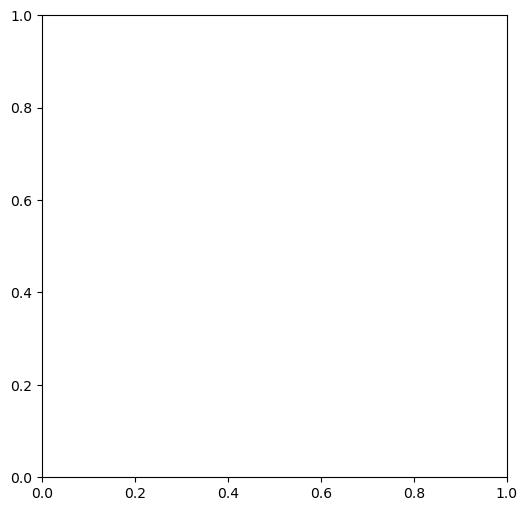

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_ci_density_estimations(comparison, algorithms=competition.algorithms, show_names=True, ax=ax)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
comparison = MOBootstrapComparison(
    competition.filter(objectives=["score", "contribution"]), 
    minimise={"score": False, "contribution": False}, 
    aggregation_method={"score": np.sum, "contribution": np.mean}, 
    bootstrap_runs=1000)
comparison.get_ranking(visualise=False)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
algs = [a for a in competition.algorithms if a not in ["Jeremy"]]
plot_ci_density_estimations(comparison, algorithms=algs, show_names=True, ax=ax)
# ax.scatter([880], [3100], color="red")
# ax.text(880, 3100, "Ideal", color="red")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# plot_ci_list(comparison, objective="contribution")
[a for a in competition.algorithms if a not in ["Jeremy"]]